<a href="https://colab.research.google.com/github/Sopralapanca/CommonLitChallenge/blob/main/KagglePrepareDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data importing and setup

In [32]:
!pip install pyspellchecker swifter transformers

In [33]:
!git clone "https://github.com/Sopralapanca/CommonLitChallenge.git"

fatal: destination path 'CommonLitChallenge' already exists and is not an empty directory.


In [34]:
import pandas as pd
import swifter

summaries_train_path = "/content/CommonLitChallenge/data/summaries_train.csv"
prompt_train_path = "/content/CommonLitChallenge/data/prompts_train.csv"

df_train_summaries = pd.read_csv(summaries_train_path, sep=',', index_col=0)
df_train_prompt = pd.read_csv(prompt_train_path, sep=',', index_col=0)

In [35]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

df_train_summaries['tokenized_text'] = df_train_summaries.swifter.apply(lambda x: tokenizer.tokenize(x.text), axis=1)
df_train_summaries['tokenized_text_len'] = df_train_summaries.swifter.apply(lambda x: len(x.tokenized_text), axis=1)
df_train_summaries.drop(columns=['tokenized_text'], inplace=True)

df_train_prompt['tokenized_prompt_text'] = df_train_prompt.swifter.apply(lambda x: tokenizer.tokenize(x.prompt_text), axis=1)
df_train_prompt['tokenized_prompt_text_len'] = df_train_prompt.swifter.apply(lambda x: len(x.tokenized_prompt_text), axis=1)
df_train_prompt.drop(columns=['tokenized_prompt_text'], inplace=True)

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

# Text processing methods

In [36]:
# normalize the data between 0 and 1 taking into consideration the prompt title

from sklearn.preprocessing import MinMaxScaler

def normalize_col(df, col):
    # Create a Min-Max Scaler
    scaler = MinMaxScaler()
    df[col] = df.groupby('prompt_id')[col].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

    return df

In [37]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
# get list of all stopwords in english
stopword_list = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
import string
from nltk.tokenize import word_tokenize
import re


def preprocessText(text, removal=True):
    # replace newline with space
    text = text.replace("\n", " ")
    text = text.replace('\r', ' ')

    # Normalize spaces around punctuation marks
    text = re.sub(r"[^A-Za-z0-9']", r' ', text)
    text = re.sub(r'\s+', ' ', text)

    # Replace curly apostrophe with straight single quote
    text = text.replace('’', "'")

    # Normalize spaces around punctuation marks
    text = text.strip()

    if removal:
      # lower case
      text = text.lower()

      # split text
      words = text.split()

      # stop word removal
      words = [w for w in words if not w in stopword_list]

      # stemming
      # words = [stemmer.stem(w) for w in words]

      # lemmatization
      #words = [lemmatizer.lemmatize(w) for w in words]

      text = ' '.join(words)

    return text

In [39]:
def add_row(df1, df2, preprocess=False):
    #append row on the head of the dataframe

    row = df2.unique().tolist()[0]

    if preprocess:
        # apply text preprocessing on the row, removing punctuation, stopwrods...
        row = preprocessText(row)

    combined_data = pd.concat([pd.Series([row]),df1.loc[:]]).reset_index(drop=True) #append row on the head of the dataframe

    return combined_data

In [40]:
# Count the stop words in the text.
def count_stopwords(text: str) -> int:
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stopword_list)
    return stopwords_count

# Count the punctuations in the text.
# punctuation_set -> !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
def count_punctuation(text: str) -> int:
    punctuation_set = set(string.punctuation)
    punctuation_count = sum(1 for char in text if char in punctuation_set)
    return punctuation_count

def different_word_counter(row):
    row = preprocessText(row, removal=False)
    words_list = []
    for w in row.split(' '):
        if w not in words_list:
            words_list.append(w)
    return len(words_list)

def count_words(text):
    return len(text.split(' '))

In [41]:
# ref https://stats.stackexchange.com/questions/570698/should-i-remove-stopwords-before-generating-n-grams
# first find ngrams, then remove the one with stopowrds

from nltk.util import ngrams
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def count_ngrams(text, n):
    text = preprocessText(text, False)

    keep_ngrams = []
    tokens = word_tokenize(text)
    try:
        n_grams = list(ngrams(tokens, n))
        all_ngrams =  [' '.join(gram) for gram in n_grams]

        # remove ngrams that starts or end with stopwords
        for ngram in all_ngrams:
            if not ngram[0] in stopword_list or not ngram[-1] in stopword_list:
                keep_ngrams.append(ngram)
    except:
        pass

    return keep_ngrams

def count_cooccurring_ngrams(text_ngrams, prompt_text_ngrams):
    # Find the common n-grams between the two columns
    common_ngrams = set(text_ngrams) & set(prompt_text_ngrams)
    return len(common_ngrams)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
import sympy

# Group by 'prompt_id' and compute TF-IDF separately for each class
def compute_TFIDF(df):
    tfidf_vectorizers = {}
    karp_tfidf_scores = {}

    for class_id, group in df.groupby('prompt_id'):
        text_data = group['text_nostop']

        prompt_question_data = group['prompt_question']
        prompt_title_data = group['prompt_title']
        prompt_text_data = group['prompt_text_nostop']

        # Concatenate the preprocessed data for TF-IDF calculation
        combined_data = add_row(text_data, prompt_question_data, True)
        combined_data = add_row(combined_data, prompt_title_data, True)
        combined_data = add_row(combined_data, prompt_text_data)

        # Compute TF-IDF
        tfidf_vectorizer = TfidfVectorizer()
        tfidf_matrix = tfidf_vectorizer.fit_transform(combined_data)
        tfidf_vectorizers[class_id] = {'vectorizer': tfidf_vectorizer, 'matrix': tfidf_matrix}

        tfidf_matrix = tfidf_matrix[3:] #remove first 3 rows f the matrix since they belongs to prompt_text, prompt_question, prompt_title

        modulus = sympy.randprime(tfidf_matrix.shape[1]-100, tfidf_matrix.shape[1])

        # Iterate through documents and calculate TF-IDF scores
        for index, row in group.iterrows():
            doc_tfidf = tfidf_matrix[index - group.index[0]].toarray()[0]

            doc_tfidf = doc_tfidf[doc_tfidf>0]

            gamma = 1e-2
            single_tfidf_score = sum([t**(gamma*i) for i, t in enumerate(doc_tfidf)]) % modulus

            karp_tfidf_scores[index] = single_tfidf_score

    # Add the calculated average TF-IDF scores as a new column to the DataFrame
    df['karp_tfidf_scores'] = [karp_tfidf_scores[index] for index in df.index]

    return df

# Preprocessing prompt dataframe before merging

In [43]:
def prompt_feature_engineer(dataframe: pd.DataFrame, feature: str = 'prompt_text') -> pd.DataFrame:
    dataframe[f'{feature}_word_cnt'] = dataframe[feature].swifter.apply(count_words)
    dataframe[f'{feature}_length'] = dataframe[feature].swifter.apply(len)
    dataframe[f'{feature}_stopword_cnt'] = dataframe[feature].swifter.apply(count_stopwords)
    dataframe[f'{feature}_punct_cnt'] = dataframe[feature].swifter.apply(count_punctuation)

    dataframe[f'{feature}_different_word_cnt'] = dataframe[feature].swifter.apply(different_word_counter)

    dataframe[f'{feature}_nostop'] = dataframe[feature].swifter.apply(preprocessText)

    # ngrams finding
    for n in range(2,5):
        col = f"{feature}_{n}grams"
        dataframe[col] = dataframe.swifter.apply(lambda row: count_ngrams(row[feature], n), axis=1)


    return dataframe

In [44]:
df_train_prompt = prompt_feature_engineer(df_train_prompt)

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

# Merging dataframe and extract features

In [45]:
df_train = df_train_summaries.merge(df_train_prompt, on='prompt_id')

In [46]:
import itertools

word_list = []
for prompt, query, title in zip(df_train_prompt.prompt_text.tolist(), df_train_prompt.prompt_question.tolist(), df_train_prompt.prompt_title.tolist()):
    word_list.append(prompt.replace('\n', ' ').split())
    word_list.append(query.replace('\n', ' ').split())
    word_list.append(title.replace('\n', ' ').split())

token_list = list(itertools.chain(*word_list))

Quick basic dataset exploration

In [47]:
df_train.describe()

,content,wording,tokenized_text_len,tokenized_prompt_text_len,prompt_text_word_cnt,prompt_text_length,prompt_text_stopword_cnt,prompt_text_punct_cnt,prompt_text_different_word_cnt
count,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000
mean,-0.014853,-0.063072,93.229170,862.368876,688.625960,3875.733845,339.530216,86.582275,313.132729
std,1.043569,1.036048,68.764623,214.650355,173.705465,784.383272,108.475611,18.936104,44.947921
min,-1.729859,-1.962614,26.000000,675.000000,550.000000,3329.000000,237.000000,55.000000,273.000000
25%,-0.799545,-0.872720,48.000000,706.000000,550.000000,3329.000000,237.000000,73.000000,273.000000
50%,-0.093814,-0.081769,71.000000,786.000000,604.000000,3360.000000,305.000000,96.000000,303.000000
75%,0.499660,0.503833,114.000000,1202.000000,966.000000,5132.000000,509.000000,108.000000,383.000000
max,3.900326,4.310693,865.000000,1202.000000,966.000000,5132.000000,509.000000,108.000000,383.000000


In [48]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7165 entries, 0 to 7164
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   prompt_id                       7165 non-null   object 
 1   text                            7165 non-null   object 
 2   content                         7165 non-null   float64
 3   wording                         7165 non-null   float64
 4   tokenized_text_len              7165 non-null   int64  
 5   prompt_question                 7165 non-null   object 
 6   prompt_title                    7165 non-null   object 
 7   prompt_text                     7165 non-null   object 
 8   tokenized_prompt_text_len       7165 non-null   int64  
 9   prompt_text_word_cnt            7165 non-null   int64  
 10  prompt_text_length              7165 non-null   int64  
 11  prompt_text_stopword_cnt        7165 non-null   int64  
 12  prompt_text_punct_cnt           71

Preprocess the data

In [49]:
from spellchecker import SpellChecker

spell = SpellChecker()

spell.word_frequency.load_words(token_list)

def misspelled(text):
    words = text.split()
    misspelled = spell.unknown(words)
    return len(misspelled)

In [50]:
import numpy as np

# This function applies all the above preprocessing functions on a text feature.
def feature_engineer(dataframe: pd.DataFrame, feature: str = 'text') -> pd.DataFrame:
    dataframe[f'{feature}_word_cnt'] = dataframe[feature].swifter.apply(count_words)
    dataframe[f'{feature}_length'] = dataframe[feature].swifter.apply(len)
    dataframe[f'{feature}_stopword_cnt'] = dataframe[feature].swifter.apply(count_stopwords)
    dataframe[f'{feature}_punct_cnt'] = dataframe[feature].swifter.apply(count_punctuation)

    # vedere se prima effetturare preprocess del testo
    dataframe[f'{feature}_different_word_cnt'] = dataframe[feature].swifter.apply(different_word_counter)


    # misspelled counter
    dataframe[f'{feature}_misspelled_cnt'] = dataframe[feature].swifter.apply(lambda x: misspelled(x))

    # ratios
    dataframe[f'{feature}_word_ratio'] = dataframe[f'{feature}_word_cnt'] / dataframe['prompt_text_word_cnt']
    dataframe.drop(['prompt_text_word_cnt'], axis=1, inplace=True)

    dataframe[f'{feature}_length_ratio'] = dataframe[f'{feature}_length'] / dataframe['prompt_text_length']
    dataframe.drop(['prompt_text_length'], axis=1, inplace=True)

    dataframe[f'{feature}_stopword_ratio'] = dataframe[f'{feature}_stopword_cnt'] / dataframe['prompt_text_stopword_cnt']
    dataframe.drop(['prompt_text_stopword_cnt'], axis=1, inplace=True)

    dataframe[f'{feature}_punct_ratio'] = dataframe[f'{feature}_punct_cnt'] / dataframe['prompt_text_punct_cnt']
    dataframe.drop(['prompt_text_punct_cnt'], axis=1, inplace=True)


    # vedere se prima effetturare preprocess del testo
    dataframe[f'{feature}_different_word_cnt'] = dataframe[feature].swifter.apply(lambda row: different_word_counter(row))

    dataframe[f'{feature}_different_word_ratio'] = dataframe[f'{feature}_different_word_cnt'] / dataframe['prompt_text_different_word_cnt']
    dataframe.drop(['prompt_text_different_word_cnt'], axis=1, inplace=True)


    dataframe[f'{feature}_nostop'] = dataframe[feature].swifter.apply(preprocessText)
    dataframe = compute_TFIDF(dataframe)

    dataframe.drop(['text_nostop', 'prompt_text_nostop'], axis=1, inplace=True)

    normalize_cols = [f'{feature}_word_cnt',f'{feature}_length',f'{feature}_stopword_cnt',
                      f'{feature}_punct_cnt', f'{feature}_misspelled_cnt',
                     f'{feature}_different_word_cnt', f'{feature}_different_word_ratio',
                     f'{feature}_word_ratio',f'{feature}_length_ratio', f'{feature}_stopword_ratio',
                     f'{feature}_punct_ratio', "karp_tfidf_scores"]

    # ngrams finding
    for n in range(2,5):
        col = f"{feature}_{n}grams"
        dataframe[col] = dataframe.swifter.apply(lambda row: count_ngrams(row[feature], n), axis=1)

        # ngrams coocurrence count
        dataframe[f"{n}grams_cnt"] = dataframe.swifter.apply(lambda row: count_cooccurring_ngrams(row[f"text_{n}grams"], row[f"prompt_text_{n}grams"]), axis=1)

        dataframe.drop([f"text_{n}grams", f"prompt_text_{n}grams"], axis=1, inplace=True)

        normalize_cols.append(f"{n}grams_cnt")


    dataframe = dataframe.replace([np.inf, -np.inf], np.nan).fillna(0)

    for col in normalize_cols:
        dataframe = normalize_col(dataframe, col)


    return dataframe

In [51]:
preprocessed_df = feature_engineer(df_train)

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

In [52]:
preprocessed_df.head()

,prompt_id,text,content,wording,tokenized_text_len,prompt_question,prompt_title,prompt_text,tokenized_prompt_text_len,text_word_cnt,...,text_misspelled_cnt,text_word_ratio,text_length_ratio,text_stopword_ratio,text_punct_ratio,text_different_word_ratio,karp_tfidf_scores,2grams_cnt,3grams_cnt,4grams_cnt
0,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,70,Summarize how the Third Wave developed over su...,The Third Wave,Background \nThe Third Wave experiment took pl...,675,0.099174,...,0.081081,0.099174,0.104635,0.087719,0.050847,0.168478,0.529881,0.016807,0.000000,0.000000
1,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,263,Summarize how the Third Wave developed over su...,The Third Wave,Background \nThe Third Wave experiment took pl...,675,0.498623,...,0.729730,0.498623,0.508031,0.479532,0.508475,0.603261,0.953371,0.126050,0.049587,0.018182
2,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,74,Summarize how the Third Wave developed over su...,The Third Wave,Background \nThe Third Wave experiment took pl...,675,0.096419,...,0.081081,0.096419,0.104176,0.099415,0.152542,0.152174,0.465352,0.058824,0.049587,0.018182
3,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,95,Summarize how the Third Wave developed over su...,The Third Wave,Background \nThe Third Wave experiment took pl...,675,0.140496,...,0.297297,0.140496,0.152822,0.146199,0.169492,0.195652,0.560326,0.092437,0.033058,0.018182
4,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,33,Summarize how the Third Wave developed over su...,The Third Wave,Background \nThe Third Wave experiment took pl...,675,0.005510,...,0.054054,0.005510,0.012391,0.011696,0.033898,0.027174,0.160165,0.025210,0.000000,0.000000


In [53]:
preprocessed_df.describe()

,content,wording,tokenized_text_len,tokenized_prompt_text_len,text_word_cnt,text_length,text_stopword_cnt,text_punct_cnt,text_different_word_cnt,text_misspelled_cnt,text_word_ratio,text_length_ratio,text_stopword_ratio,text_punct_ratio,text_different_word_ratio,karp_tfidf_scores,2grams_cnt,3grams_cnt,4grams_cnt
count,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000
mean,-0.014853,-0.063072,93.229170,862.368876,0.100120,0.098436,0.118987,0.095105,0.143390,0.119816,0.100120,0.098436,0.118987,0.095105,0.143390,0.455192,0.091177,0.064471,0.053944
std,1.043569,1.036048,68.764623,214.650355,0.105828,0.102808,0.108247,0.093756,0.117075,0.100842,0.105828,0.102808,0.108247,0.093756,0.117075,0.229856,0.101116,0.095480,0.093230
min,-1.729859,-1.962614,26.000000,675.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.799545,-0.872720,48.000000,706.000000,0.030547,0.030827,0.047826,0.034483,0.061151,0.051282,0.030547,0.030827,0.047826,0.034483,0.061151,0.274284,0.025806,0.006711,0.000000
50%,-0.093814,-0.081769,71.000000,786.000000,0.065708,0.064286,0.083045,0.067901,0.109091,0.093023,0.065708,0.064286,0.083045,0.067901,0.109091,0.425575,0.058824,0.026846,0.013158
75%,0.499660,0.503833,114.000000,1202.000000,0.134185,0.130786,0.156522,0.118644,0.190698,0.153846,0.134185,0.130786,0.156522,0.118644,0.190698,0.620035,0.117647,0.085938,0.070588
max,3.900326,4.310693,865.000000,1202.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [54]:
preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7165 entries, 0 to 7164
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   prompt_id                  7165 non-null   object 
 1   text                       7165 non-null   object 
 2   content                    7165 non-null   float64
 3   wording                    7165 non-null   float64
 4   tokenized_text_len         7165 non-null   int64  
 5   prompt_question            7165 non-null   object 
 6   prompt_title               7165 non-null   object 
 7   prompt_text                7165 non-null   object 
 8   tokenized_prompt_text_len  7165 non-null   int64  
 9   text_word_cnt              7165 non-null   float64
 10  text_length                7165 non-null   float64
 11  text_stopword_cnt          7165 non-null   float64
 12  text_punct_cnt             7165 non-null   float64
 13  text_different_word_cnt    7165 non-null   float

Extract feature columns

In [55]:
FEATURE_COLUMNS = preprocessed_df.drop(columns = ['prompt_id', 'text', 'prompt_question',
                                           'prompt_title', 'prompt_text', 'content', 'wording'], axis = 1).columns.to_list()

In [56]:
FEATURE_COLUMNS

['tokenized_text_len',
 'tokenized_prompt_text_len',
 'text_word_cnt',
 'text_length',
 'text_stopword_cnt',
 'text_punct_cnt',
 'text_different_word_cnt',
 'text_misspelled_cnt',
 'text_word_ratio',
 'text_length_ratio',
 'text_stopword_ratio',
 'text_punct_ratio',
 'text_different_word_ratio',
 'karp_tfidf_scores',
 '2grams_cnt',
 '3grams_cnt',
 '4grams_cnt']

# Dataset analysis

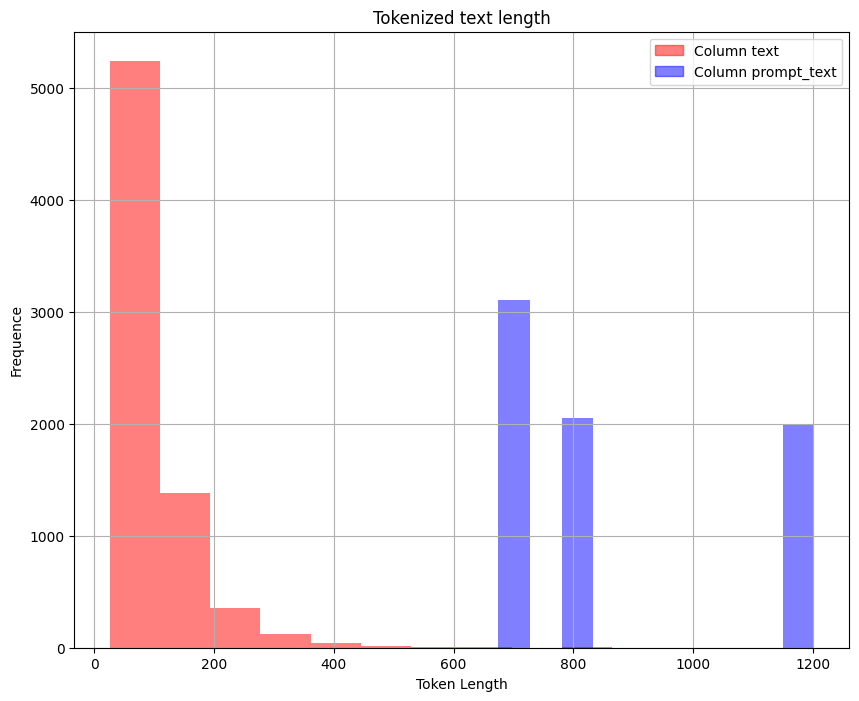

In [57]:

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10, 8))

preprocessed_df.hist(column='tokenized_text_len', ax=ax, alpha=0.5, color='red')
preprocessed_df.hist(column='tokenized_prompt_text_len', ax=ax, alpha=0.5, color='blue')
ax.set_title('Tokenized text length')
ax.set_xlabel('Token Length')
ax.set_ylabel('Frequence')
red_patch = mpatches.Patch(alpha=0.5, color='red', label='Column text')
blue_patch = mpatches.Patch(alpha=0.5, color='blue', label='Column prompt_text')
plt.legend(handles=[red_patch, blue_patch])

training_data = normalize_col(preprocessed_df, "tokenized_text_len")
training_data.drop(columns=['tokenized_prompt_text_len', 'tokenized_text_len'], inplace=True)

In [58]:
content_corr = preprocessed_df.corrwith(training_data['content'], numeric_only=True)
content_corr

content                      1.000000
wording                      0.751380
text_word_cnt                0.775117
text_length                  0.781679
text_stopword_cnt            0.754161
text_punct_cnt               0.674796
text_different_word_cnt      0.797559
text_misspelled_cnt          0.688076
text_word_ratio              0.775117
text_length_ratio            0.781679
text_stopword_ratio          0.754161
text_punct_ratio             0.674796
text_different_word_ratio    0.797559
karp_tfidf_scores            0.836458
2grams_cnt                   0.484114
3grams_cnt                   0.380463
4grams_cnt                   0.335114
dtype: float64

In [59]:
wording_corr = preprocessed_df.corrwith(training_data['wording'], numeric_only=True)
wording_corr

content                      0.751380
wording                      1.000000
text_word_cnt                0.550746
text_length                  0.556444
text_stopword_cnt            0.538670
text_punct_cnt               0.451824
text_different_word_cnt      0.552428
text_misspelled_cnt          0.556402
text_word_ratio              0.550746
text_length_ratio            0.556444
text_stopword_ratio          0.538670
text_punct_ratio             0.451824
text_different_word_ratio    0.552428
karp_tfidf_scores            0.568533
2grams_cnt                   0.143873
3grams_cnt                   0.042589
4grams_cnt                   0.013430
dtype: float64

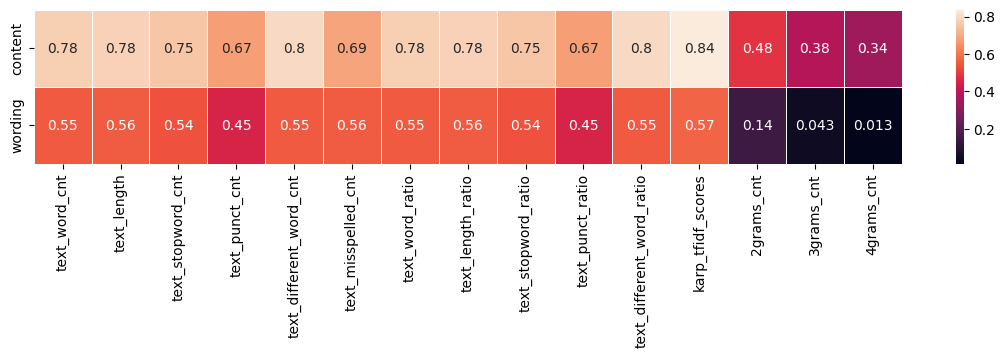

In [60]:
import seaborn as sn
import matplotlib.pyplot as plt
x_labels = content_corr.axes[0].tolist()
y_labels = ['content', 'wording']
fig, ax = plt.subplots(figsize=(14,2))
ax = sn.heatmap([content_corr[2:], wording_corr[2:]], xticklabels=x_labels[2:], yticklabels=y_labels, annot=True, linewidths=.5)
plt.show()

In [61]:
preprocessed_df.to_csv('dataset.csv', index=False)

In [62]:
!zip -r 'dataset.zip' 'dataset.csv' # download and save in github

updating: dataset.csv (deflated 95%)
